In [1]:
from env import *
import scipy.special

Load LCDB data:

In [2]:
lcdb_df = pd.read_csv(os.path.expanduser('~/Documents/data/delegated_classification/lcdb/database/database-accuracy.csv'))
lcdb_df.head()

build_cdp = lambda learner, openmlid, m: (
    lcdb_df
    .query('openmlid==@openmlid and learner==@learner')
    .groupby('size_train')
    ['score_test']
    .agg(list)
    .pipe(
        dclf.BootstrappedBinomialMixtureContractDesignProblem.from_series,
        m=m,
        ensure_zero_cost_action=True,
    )
)

selected_openmlid = dclf.mnist_openmlid
selected_learner = 'sklearn.neural_network.MLPClassifier'

In [3]:
m = param(30,'m')

Fit power-law curve:

In [4]:
cdp = build_cdp(selected_learner, selected_openmlid, m=m)
x = cdp.cost[1:]
y = cdp.mean_acc[1:]
pow3 = dclf.Pow3.from_data(x, y)
pow3.params

array([1.        , 1.88529988, 0.33066663])

In [5]:
param(pow3.params[1].round(2),'beta')
param(pow3.params[2].round(2),'gamma')

0.33

Calculate survival function and bounds based on the power-law curve:

In [6]:
n = np.array(cdp.cost[1:])
alpha,beta,gamma=pow3.params
assert np.isclose(alpha,1)

# Resample n
n = np.linspace(n.min(), n.max(),300)

# Expected accuracy
acc_f = lambda n: alpha-beta*n**-gamma
acc = acc_f(n)

# Stochastic learning curve
f_ij = np.vstack([
    stats.binom.pmf(np.arange(0,m+1), m, p)
    for p in acc
])
j0 = lambda p,q: (q-p>=0).argmax()
j = j0(*f_ij[-2:])

# Calculate inflection point and upper bound
n_crit = (beta*(m+gamma**-1)/(m+1-j+gamma**-1))**(gamma**-1)
param(round(n_crit), 'inflection_point')
n_bound = (beta*(m+gamma**-1)/(1+gamma**-1))**(gamma**-1)
param(round(n_bound), 'inflection_point_bound')
# n_bound = (beta*(m+gamma**-1)/(beta*(m+1)*N**-gamma+gamma**-1))**(gamma**-1)

# Survival at likelihood transition
sf_ij = 1-f_ij.cumsum(axis=1)
s_i = sf_ij[:,j-1]

# Second derivative
dn = n[1]-n[0]
ds_dn = np.diff(s_i)/dn
dds_dnn = np.diff(ds_dn)/dn

# Representation of survival using regularized incomplete beta function
s_p = lambda p: scipy.special.betainc(j,m+1-j,p)

Plot:

2022.4894095997954 3957.1337051126943
16.0


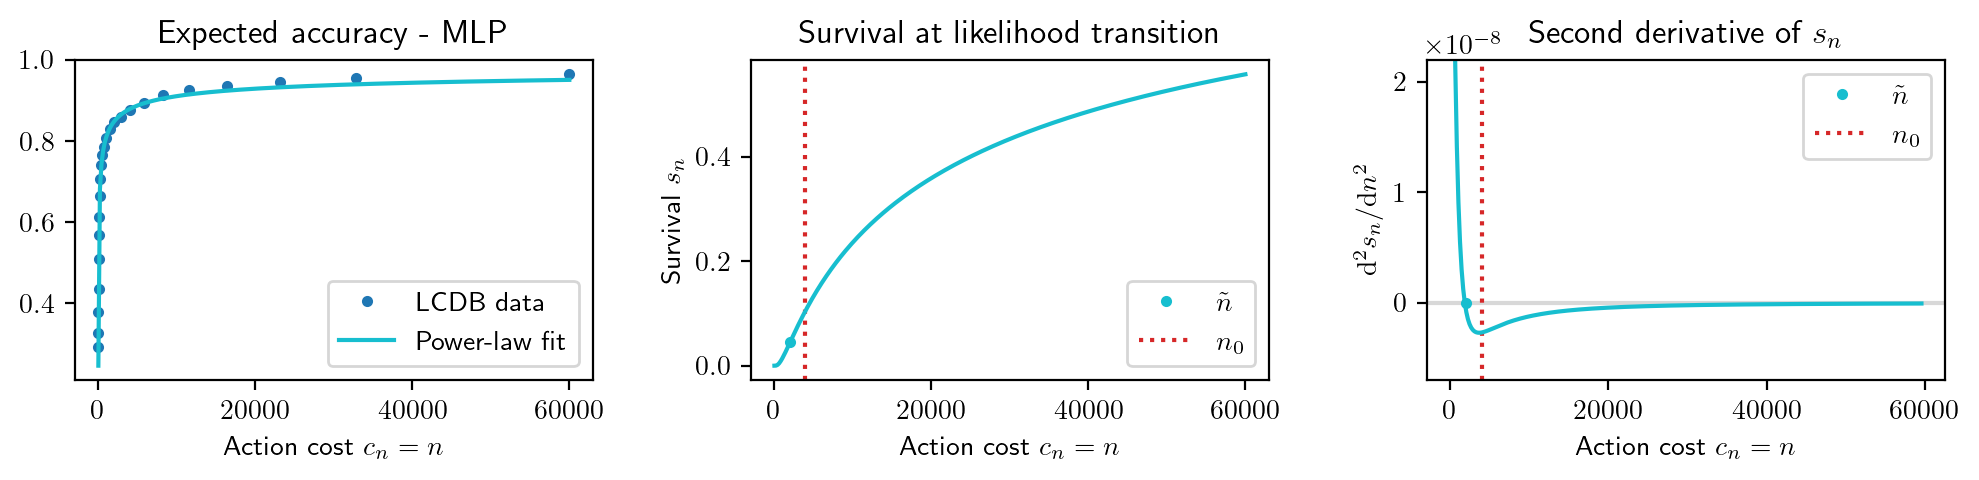

In [7]:
fig,axs = plt.subplots(1,3,figsize=(10,2.5),tight_layout={'w_pad':2})
axs_it = iter(axs.ravel())
c = 'tab:cyan'
n_crit_label = '$\\tilde{n}$'
n_bound_label = '$n_0$'

# Expected learning curve
ax = next(axs_it)
ax.plot(x,y,'.',label='LCDB data')
ax.plot(n,acc,'-',color=c, label='Power-law fit')
ax.set(
    title=f'Expected accuracy - {dclf.lcdb_learner_names[selected_learner]}',
    xlabel='Action cost $c_n=n$',
)
ax.legend()

# Survival
ax = next(axs_it)
ax.plot(n,s_i,color=c)
ax.plot(
    n_crit,
    s_p(acc_f(n_crit)),
    '.',
    color=c,
    label=n_crit_label,
)
ax.axvline(
    n_bound,
    linestyle=':',
    color='tab:red',
    zorder=-2,
    label=n_bound_label,
)
ax.set(
    title='Survival at likelihood transition',
    xlabel='Action cost $c_n=n$',
    ylabel='Survival $s_n$',
)
ax.legend()

# Second derivative
ax = next(axs_it)
ax.plot(n[:-2],dds_dnn,color=c)
ax.plot(
    n_crit,
    0,
    '.',
    color=c,
    label=n_crit_label,
)
ax.axvline(
    n_bound,
    linestyle=':',
    color='tab:red',
    zorder=-2,
    label=n_bound_label,
)
ax.axhline(
    0,
    linestyle='-',
    color='tab:gray',
    zorder=-3,
    alpha=0.3,
)
ax.set(
    title='Second derivative of $s_n$',
    xlabel='Action cost $c_n=n$',
    ylabel='${\\mathrm{d}^2s_n}/{\\mathrm{d}n^2}$',
    ylim=(-0.7e-8,2.2e-8)
)
ax.legend()

print(n_crit, n_bound)
print(n.min())

In [8]:
dclf.save_and_download_fig(fig, './output/binomial_concave_survival.pdf')
tracker.save('./output/binomial_concave_survival.json')

Figure saved as ./output/binomial_concave_survival.pdf
